# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 3, #degree
        'n': 10, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 10,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'polynomial_data_size': 1000,  #number of generated polynomials (for loading)
        'lambda_nets_total': 1000, #number of lambda-nets to train
        'noise': 0.2,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,         
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000, #lambda-net training dataset size
    },    
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': False,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
    
        'random_evaluation_dataset_size': 500,
    },    
    'computation':{
        'n_jobs': 3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys
import os

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
import random 


import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n] 

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda

if same_training_all_lambda_nets:
    training_string = '_same'
else:
    training_string = '_diverse'
    
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [5]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 286
[[3, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 1, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 1, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 1, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 1, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 1, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 1, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 1], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 1, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 1, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 1, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0, 1], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 2, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 1, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 1, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0, 1, 0], [1, 0, 1, 0, 0, 0, 0, 0, 0, 1], [1, 0, 1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 2, 0, 0, 0, 

In [6]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis

config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)

config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']
    
transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

initialize_utility_functions_config_from_curent_notebook(config)
initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>


In [7]:
print(path_identifier_lambda_net_data)

print(path_identifier_polynomial_data)


lnets_1000_50-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_10_d_3_negd_0_prob_0_spars_10_amin_-1_amax_1_xdist_uniform_noise_normal_0.2bmin0.2bmax0.4lowd0.5azero0.25arand0.1
poly_1000_train_5000_var_10_d_3_negd_0_prob_0_spars_10_amin_-1_amax_1_xdist_uniform_noise_normal_0.2bmin0.2bmax0.4lowd0.5azero0.25arand0.1_diffX


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [9]:
lambda_network_layers

[50]

In [10]:
path_polynomials = './data/saved_polynomial_lists/polynomials_sample_' + path_identifier_polynomial_data + '.csv'
polynomials_list_df = pd.read_csv(path_polynomials)

path_X_data = './data/saved_polynomial_lists/X_sample_' + path_identifier_polynomial_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_polynomial_lists/y_sample_' + path_identifier_polynomial_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
if lambda_nets_total < polynomial_data_size:
    polynomials_list_df = polynomials_list_df.sample(n=lambda_nets_total, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, lambda_nets_total)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, lambda_nets_total)
    random.seed(RANDOM_SEED)

## Data Inspection

In [11]:
X_data_list[0][1].head(10)

,a,b,c,d,e,f,g,h,i,j
0,0.549,0.715,0.603,0.545,0.424,0.646,0.438,0.892,0.964,0.383
1,0.792,0.529,0.568,0.926,0.071,0.087,0.020,0.833,0.778,0.870
2,0.979,0.799,0.461,0.781,0.118,0.640,0.143,0.945,0.522,0.415
3,0.265,0.774,0.456,0.568,0.019,0.618,0.612,0.617,0.944,0.682
4,0.360,0.437,0.698,0.060,0.667,0.671,0.210,0.129,0.315,0.364
5,0.570,0.439,0.988,0.102,0.209,0.161,0.653,0.253,0.466,0.244
6,0.159,0.110,0.656,0.138,0.197,0.369,0.821,0.097,0.838,0.096
7,0.976,0.469,0.977,0.605,0.739,0.039,0.283,0.120,0.296,0.119
8,0.318,0.414,0.064,0.692,0.567,0.265,0.523,0.094,0.576,0.929
9,0.319,0.667,0.132,0.716,0.289,0.183,0.587,0.020,0.829,0.005


In [12]:
y_data_list[0][1].head(10)

,result
0,-0.471
1,0.304
2,-0.386
3,-0.041
4,-0.006
5,0.351
6,-1.257
7,-0.089
8,-1.092
9,-1.333


In [13]:
X_data_list[0][0].head(10)

3000000000   0.098
2100000000   0.000
2010000000   0.000
2001000000   0.090
2000100000   0.000
2000010000   0.000
2000001000   0.000
2000000100   0.000
2000000010   0.000
2000000001   0.000
dtype: float64

In [14]:
y_data_list[0][0].head(10)

3000000000   0.098
2100000000   0.000
2010000000   0.000
2001000000   0.090
2000100000   0.000
2000010000   0.000
2000001000   0.000
2000000100   0.000
2000000010   0.000
2000000001   0.000
dtype: float64

## Lambda Network Training + Weigh/Bias saving

In [15]:
#%autoreload 2
clf_list = []
chunksize = 5000 if lambda_nets_total > 50000 else max(lambda_nets_total//10, min(50, lambda_nets_total))
X_data_list_splits = list(chunks(X_data_list, chunksize))
y_data_list_splits = list(chunks(y_data_list, chunksize))

max_seed = 2147483646
seed_list = random.sample(range(0, max_seed), number_different_lambda_trainings)
chunk_multiplier = 0

for X_data_list_split, y_data_list_split in tqdm(zip(X_data_list_splits, y_data_list_splits), total=max(len(X_data_list_splits), len(y_data_list_splits))):
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    clf_sublist = parallel(delayed(train_nn)(chunksize*chunk_multiplier+index, X_data[1].values, y_data[1].values, X_data[0], seed_list, return_history=True, each_epochs_save=each_epochs_save_lambda, printing=True) for index, (X_data, y_data) in enumerate(zip(X_data_list_split, y_data_list_split)))  
    clf_list.extend(clf_sublist)
    del parallel
    chunk_multiplier +=1

  0%|          | 0/10 [00:00<?, ?it/s]

[Parallel(n_jobs=3)]: Using backend MultiprocessingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  2.9min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 10.7min finished
[Parallel(n_jobs=3)]: Using backend MultiprocessingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 12.4min finished
[Parallel(n_jobs=3)]: Using backend MultiprocessingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  4.2min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 15.0min finished
[Parallel(n_jobs=3)]: Using backend MultiprocessingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 14.8min finished
[Parallel(n_jobs=3)]: Using backend MultiprocessingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | el

In [16]:
#%load_ext autoreload

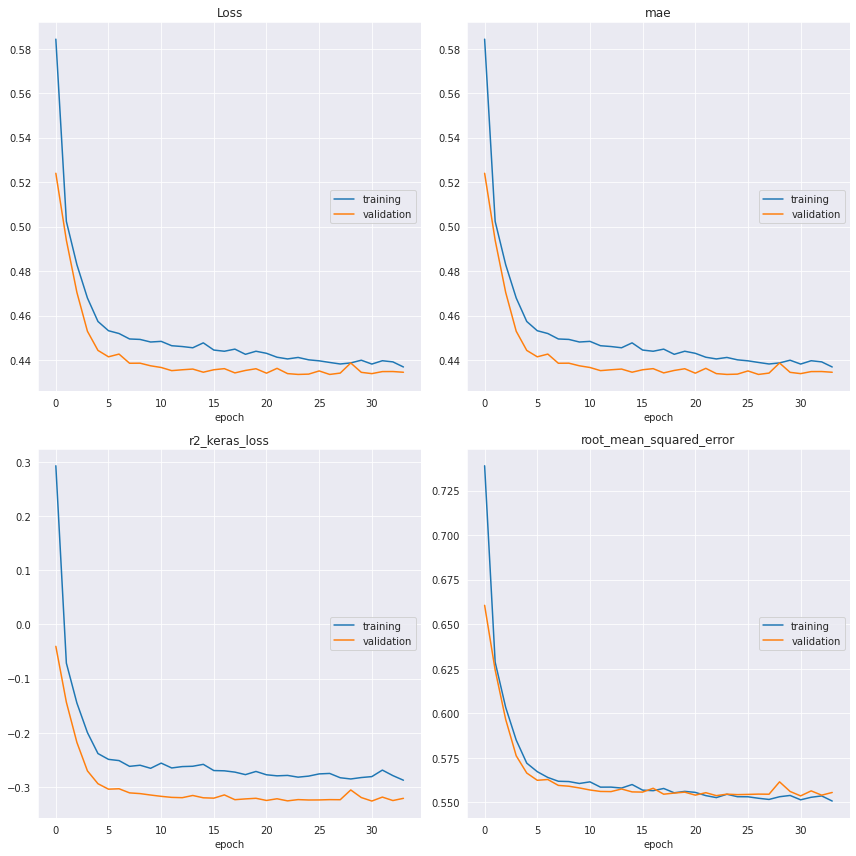

Loss
	training         	 (min:    0.437, max:    0.584, cur:    0.437)
	validation       	 (min:    0.434, max:    0.524, cur:    0.435)
mae
	training         	 (min:    0.437, max:    0.584, cur:    0.437)
	validation       	 (min:    0.434, max:    0.524, cur:    0.435)
r2_keras_loss
	training         	 (min:   -0.288, max:    0.293, cur:   -0.288)
	validation       	 (min:   -0.326, max:   -0.041, cur:   -0.321)
root_mean_squared_error
	training         	 (min:    0.551, max:    0.739, cur:    0.551)
	validation       	 (min:    0.554, max:    0.661, cur:    0.556)


In [17]:
#%autoreload 2
rand_index = np.random.randint(lambda_nets_total)

random_network = train_nn(rand_index, X_data_list[rand_index][1], y_data_list[rand_index][1], X_data_list[rand_index][0], seed_list, callbacks=[PlotLossesKerasTF()], return_model=True)

## Save and Plot Lambda-Model History

In [18]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry[3]
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry[3]
    index = entry[0][0]
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=list(flatten(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=list(flatten(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))) 
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=list(flatten(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=list(flatten(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [19]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [20]:
loss_df.describe()

,index,loss_epoch_1,loss_epoch_2,loss_epoch_3,loss_epoch_4,loss_epoch_5,loss_epoch_6,loss_epoch_7,loss_epoch_8,loss_epoch_9,loss_epoch_10,loss_epoch_11,loss_epoch_12,loss_epoch_13,loss_epoch_14,loss_epoch_15,loss_epoch_16,loss_epoch_17,loss_epoch_18,loss_epoch_19,loss_epoch_20,loss_epoch_21,loss_epoch_22,loss_epoch_23,loss_epoch_24,loss_epoch_25,loss_epoch_26,loss_epoch_27,loss_epoch_28,loss_epoch_29,loss_epoch_30,loss_epoch_31,loss_epoch_32,loss_epoch_33,loss_epoch_34,loss_epoch_35,loss_epoch_36,loss_epoch_37,loss_epoch_38,loss_epoch_39,loss_epoch_40,loss_epoch_41,loss_epoch_42,loss_epoch_43,loss_epoch_44,loss_epoch_45,loss_epoch_46,loss_epoch_47,loss_epoch_48,loss_epoch_49,loss_epoch_50,loss_epoch_51,loss_epoch_52,loss_epoch_53,loss_epoch_54,loss_epoch_55,loss_epoch_56,loss_epoch_57,loss_epoch_58,loss_epoch_59,loss_epoch_60,loss_epoch_61,loss_epoch_62,loss_epoch_63,loss_epoch_64,loss_epoch_65,loss_epoch_66,loss_epoch_67,loss_epoch_68,loss_epoch_69,loss_epoch_70,loss_epoch_71,loss_epoch_72,loss_epoch_73,loss_epoch_74,loss_epoch_75,loss_epoch_76,loss_epoch_77,loss_epoch_78,loss_epoch_79,loss_epoch_80,loss_epoch_81,loss_epoch_82,loss_epoch_83,loss_epoch_84,loss_epoch_85,loss_epoch_86,loss_epoch_87,loss_epoch_88,loss_epoch_89,loss_epoch_90,loss_epoch_91,loss_epoch_92,loss_epoch_93,loss_epoch_94,loss_epoch_95,loss_epoch_96,loss_epoch_97,loss_epoch_98,loss_epoch_99,loss_epoch_100,loss_epoch_101,loss_epoch_102,loss_epoch_103,loss_epoch_104,loss_epoch_105,loss_epoch_106,loss_epoch_107,loss_epoch_108
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,997.000,991.000,987.000,984.000,981.000,971.000,968.000,966.000,960.000,952.000,945.000,933.000,927.000,911.000,901.000,892.000,875.000,859.000,836.000,815.000,790.000,751.000,739.000,721.000,693.000,661.000,634.000,607.000,579.000,558.000,532.000,502.000,484.000,455.000,430.000,409.000,388.000,357.000,331.000,309.000,292.000,268.000,241.000,221.000,205.000,195.000,179.000,163.000,151.000,137.000,123.000,116.000,108.000,99.000,90.000,85.000,77.000,69.000,67.000,60.000,56.000,52.000,48.000,43.000,40.000,31.000,30.000,27.000,25.000,23.000,21.000,17.000,15.000,14.000,14.000,12.000,12.000,11.000,10.000,9.000,8.000,7.000,6.000,6.000,6.000,6.000,5.000,4.000,4.000,3.000,2.000,2.000
mean,499.500,0.550,0.468,0.445,0.432,0.425,0.422,0.420,0.418,0.417,0.416,0.415,0.414,0.414,0.413,0.412,0.411,0.411,0.410,0.409,0.409,0.407,0.407,0.406,0.406,0.405,0.405,0.404,0.404,0.404,0.403,0.403,0.402,0.401,0.401,0.400,0.401,0.402,0.403,0.403,0.403,0.403,0.404,0.403,0.405,0.405,0.404,0.406,0.406,0.407,0.406,0.406,0.406,0.407,0.406,0.407,0.406,0.406,0.408,0.407,0.410,0.409,0.408,0.411,0.412,0.413,0.418,0.419,0.425,0.424,0.426,0.423,0.422,0.424,0.424,0.424,0.423,0.422,0.420,0.423,0.419,0.421,0.419,0.420,0.415,0.409,0.409,0.408,0.399,0.394,0.389,0.389,0.384,0.384,0.379,0.382,0.366,0.349,0.355,0.364,0.364,0.364,0.364,0.372,0.355,0.355,0.345,0.327,0.326
std,288.819,0.140,0.104,0.101,0.097,0.095,0.094,0.093,0.093,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.090,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.090,0.089,0.088,0.088,0.088,0.088,0.088,0.088,0.089,0.086,0.087,0.087,0.086,0.086,0.086,0.086,0.087,0.087,0.087,0.088,0.088,0.089,0.089,0.090,0.092,0.092,0.092,0.089,0.089,0.088,0.090,0.088,0.090,0.092,0.093,0.094,0.095,0.095,0.096,0.092,0.091,0.084,0.085,0.087,0.083,0.086,0.084,0.081,0.085,0.087,0.087,0.077,0.077,0.079,0.083,0.068,0.049,0.051,0.047,0.047,0.048,0.047,0.047,0.032,0.033,0.031,0.004,0.003
min,0.000,0.275,0.207,0.180,0.170,0.169,0.167,0.166,0.166,0.165,0.165,0.164,0.163,0.163,0.163,0.163,0.162,0.161,0.161,0.160,0.159,0.159,0.158,0.158,0.158,0.158,0.157,0.157,0.157,0.156,0.157,0.156,0.155,0.156,0.156,0.155,0.155,0.154,0.173,0.172,0.173,0.189,0.187,0.187,0.187,0.187,0.187,0.187,0.186,0.187,0.221,0.221,0

In [21]:
val_loss_df.describe()

,index,val_loss_epoch_1,val_loss_epoch_2,val_loss_epoch_3,val_loss_epoch_4,val_loss_epoch_5,val_loss_epoch_6,val_loss_epoch_7,val_loss_epoch_8,val_loss_epoch_9,val_loss_epoch_10,val_loss_epoch_11,val_loss_epoch_12,val_loss_epoch_13,val_loss_epoch_14,val_loss_epoch_15,val_loss_epoch_16,val_loss_epoch_17,val_loss_epoch_18,val_loss_epoch_19,val_loss_epoch_20,val_loss_epoch_21,val_loss_epoch_22,val_loss_epoch_23,val_loss_epoch_24,val_loss_epoch_25,val_loss_epoch_26,val_loss_epoch_27,val_loss_epoch_28,val_loss_epoch_29,val_loss_epoch_30,val_loss_epoch_31,val_loss_epoch_32,val_loss_epoch_33,val_loss_epoch_34,val_loss_epoch_35,val_loss_epoch_36,val_loss_epoch_37,val_loss_epoch_38,val_loss_epoch_39,val_loss_epoch_40,val_loss_epoch_41,val_loss_epoch_42,val_loss_epoch_43,val_loss_epoch_44,val_loss_epoch_45,val_loss_epoch_46,val_loss_epoch_47,val_loss_epoch_48,val_loss_epoch_49,val_loss_epoch_50,val_loss_epoch_51,val_loss_epoch_52,val_loss_epoch_53,val_loss_epoch_54,val_loss_epoch_55,val_loss_epoch_56,val_loss_epoch_57,val_loss_epoch_58,val_loss_epoch_59,val_loss_epoch_60,val_loss_epoch_61,val_loss_epoch_62,val_loss_epoch_63,val_loss_epoch_64,val_loss_epoch_65,val_loss_epoch_66,val_loss_epoch_67,val_loss_epoch_68,val_loss_epoch_69,val_loss_epoch_70,val_loss_epoch_71,val_loss_epoch_72,val_loss_epoch_73,val_loss_epoch_74,val_loss_epoch_75,val_loss_epoch_76,val_loss_epoch_77,val_loss_epoch_78,val_loss_epoch_79,val_loss_epoch_80,val_loss_epoch_81,val_loss_epoch_82,val_loss_epoch_83,val_loss_epoch_84,val_loss_epoch_85,val_loss_epoch_86,val_loss_epoch_87,val_loss_epoch_88,val_loss_epoch_89,val_loss_epoch_90,val_loss_epoch_91,val_loss_epoch_92,val_loss_epoch_93,val_loss_epoch_94,val_loss_epoch_95,val_loss_epoch_96,val_loss_epoch_97,val_loss_epoch_98,val_loss_epoch_99,val_loss_epoch_100,val_loss_epoch_101,val_loss_epoch_102,val_loss_epoch_103,val_loss_epoch_104,val_loss_epoch_105,val_loss_epoch_106,val_loss_epoch_107,val_loss_epoch_108
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,997.000,991.000,987.000,984.000,981.000,971.000,968.000,966.000,960.000,952.000,945.000,933.000,927.000,911.000,901.000,892.000,875.000,859.000,836.000,815.000,790.000,751.000,739.000,721.000,693.000,661.000,634.000,607.000,579.000,558.000,532.000,502.000,484.000,455.000,430.000,409.000,388.000,357.000,331.000,309.000,292.000,268.000,241.000,221.000,205.000,195.000,179.000,163.000,151.000,137.000,123.000,116.000,108.000,99.000,90.000,85.000,77.000,69.000,67.000,60.000,56.000,52.000,48.000,43.000,40.000,31.000,30.000,27.000,25.000,23.000,21.000,17.000,15.000,14.000,14.000,12.000,12.000,11.000,10.000,9.000,8.000,7.000,6.000,6.000,6.000,6.000,5.000,4.000,4.000,3.000,2.000,2.000
mean,499.500,0.483,0.455,0.438,0.430,0.425,0.423,0.422,0.421,0.420,0.420,0.419,0.419,0.419,0.418,0.418,0.417,0.417,0.416,0.416,0.416,0.415,0.415,0.415,0.414,0.414,0.413,0.414,0.414,0.414,0.413,0.413,0.413,0.412,0.412,0.412,0.413,0.414,0.416,0.416,0.416,0.417,0.417,0.417,0.419,0.419,0.419,0.420,0.421,0.423,0.422,0.421,0.422,0.422,0.422,0.423,0.422,0.423,0.425,0.424,0.427,0.426,0.425,0.428,0.429,0.430,0.435,0.436,0.443,0.441,0.444,0.440,0.439,0.442,0.442,0.443,0.442,0.441,0.439,0.443,0.440,0.442,0.442,0.443,0.439,0.432,0.430,0.430,0.422,0.416,0.409,0.410,0.403,0.404,0.400,0.405,0.391,0.373,0.379,0.389,0.389,0.389,0.389,0.400,0.380,0.381,0.372,0.355,0.358
std,288.819,0.107,0.103,0.099,0.096,0.094,0.094,0.093,0.093,0.093,0.093,0.093,0.092,0.093,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.092,0.091,0.092,0.092,0.092,0.092,0.092,0.091,0.091,0.091,0.090,0.089,0.089,0.089,0.090,0.089,0.090,0.090,0.088,0.089,0.089,0.088,0.088,0.087,0.088,0.089,0.090,0.089,0.090,0.090,0.091,0.092,0.093,0.094,0.094,0.094,0.091,0.091,0.089,0.091,0.089,0.092,0.094,0.095,0.096,0.098,0.097,0.099,0.093,0.092,0.087,0.088,0.091,0.085,0.088,0.086,0.082,0.085

In [22]:
metric_df.describe()

,index,r2_keras_loss_epoch_1,r2_keras_loss_epoch_2,r2_keras_loss_epoch_3,r2_keras_loss_epoch_4,r2_keras_loss_epoch_5,r2_keras_loss_epoch_6,r2_keras_loss_epoch_7,r2_keras_loss_epoch_8,r2_keras_loss_epoch_9,r2_keras_loss_epoch_10,r2_keras_loss_epoch_11,r2_keras_loss_epoch_12,r2_keras_loss_epoch_13,r2_keras_loss_epoch_14,r2_keras_loss_epoch_15,r2_keras_loss_epoch_16,r2_keras_loss_epoch_17,r2_keras_loss_epoch_18,r2_keras_loss_epoch_19,r2_keras_loss_epoch_20,r2_keras_loss_epoch_21,r2_keras_loss_epoch_22,r2_keras_loss_epoch_23,r2_keras_loss_epoch_24,r2_keras_loss_epoch_25,r2_keras_loss_epoch_26,r2_keras_loss_epoch_27,r2_keras_loss_epoch_28,r2_keras_loss_epoch_29,r2_keras_loss_epoch_30,r2_keras_loss_epoch_31,r2_keras_loss_epoch_32,r2_keras_loss_epoch_33,r2_keras_loss_epoch_34,r2_keras_loss_epoch_35,r2_keras_loss_epoch_36,r2_keras_loss_epoch_37,r2_keras_loss_epoch_38,r2_keras_loss_epoch_39,r2_keras_loss_epoch_40,r2_keras_loss_epoch_41,r2_keras_loss_epoch_42,r2_keras_loss_epoch_43,r2_keras_loss_epoch_44,r2_keras_loss_epoch_45,r2_keras_loss_epoch_46,r2_keras_loss_epoch_47,r2_keras_loss_epoch_48,r2_keras_loss_epoch_49,r2_keras_loss_epoch_50,r2_keras_loss_epoch_51,r2_keras_loss_epoch_52,r2_keras_loss_epoch_53,r2_keras_loss_epoch_54,r2_keras_loss_epoch_55,r2_keras_loss_epoch_56,r2_keras_loss_epoch_57,r2_keras_loss_epoch_58,r2_keras_loss_epoch_59,r2_keras_loss_epoch_60,r2_keras_loss_epoch_61,r2_keras_loss_epoch_62,r2_keras_loss_epoch_63,r2_keras_loss_epoch_64,r2_keras_loss_epoch_65,r2_keras_loss_epoch_66,r2_keras_loss_epoch_67,r2_keras_loss_epoch_68,r2_keras_loss_epoch_69,r2_keras_loss_epoch_70,r2_keras_loss_epoch_71,r2_keras_loss_epoch_72,r2_keras_loss_epoch_73,r2_keras_loss_epoch_74,r2_keras_loss_epoch_75,r2_keras_loss_epoch_76,r2_keras_loss_epoch_77,r2_keras_loss_epoch_78,r2_keras_loss_epoch_79,r2_keras_loss_epoch_80,r2_keras_loss_epoch_81,r2_keras_loss_epoch_82,r2_keras_loss_epoch_83,r2_keras_loss_epoch_84,r2_keras_loss_epoch_85,r2_keras_loss_epoch_86,r2_keras_loss_epoch_87,r2_keras_loss_epoch_88,r2_keras_loss_epoch_89,r2_keras_loss_epoch_90,r2_keras_loss_epoch_91,r2_keras_loss_epoch_92,r2_keras_loss_epoch_93,r2_keras_loss_epoch_94,r2_keras_loss_epoch_95,r2_keras_loss_epoch_96,r2_keras_loss_epoch_97,r2_keras_loss_epoch_98,r2_keras_loss_epoch_99,r2_keras_loss_epoch_100,r2_keras_loss_epoch_101,r2_keras_loss_epoch_102,r2_keras_loss_epoch_103,r2_keras_loss_epoch_104,r2_keras_loss_epoch_105,r2_keras_loss_epoch_106,r2_keras_loss_epoch_107,r2_keras_loss_epoch_108
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,997.000,991.000,987.000,984.000,981.000,971.000,968.000,966.000,960.000,952.000,945.000,933.000,927.000,911.000,901.000,892.000,875.000,859.000,836.000,815.000,790.000,751.000,739.000,721.000,693.000,661.000,634.000,607.000,579.000,558.000,532.000,502.000,484.000,455.000,430.000,409.000,388.000,357.000,331.000,309.000,292.000,268.000,241.000,221.000,205.000,195.000,179.000,163.000,151.000,137.000,123.000,116.000,108.000,99.000,90.000,85.000,77.000,69.000,67.000,60.000,56.000,52.000,48.000,43.000,40.000,31.000,30.000,27.000,25.000,23.000,21.000,17.000,15.000,14.000,14.000,12.000,12.000,11.000,10.000,9.000,8.000,7.000,6.000,6.000,6.000,6.000,5.000,4.000,4.000,3.000,2.000,2.000
mean,499.500,0.362,-0.046,-0.140,-0.189,-0.212,-0.223,-0.230,-0.234,-0.238,-0.241,-0.244,-0.247,-0.249,-0.251,-0.254,-0.256,-0.257,-0.259,-0.261,-0.263,-0.264,-0.266,-0.268,-0.269,-0.270,-0.272,-0.273,-0.274,-0.275,-0.277,-0.278,-0.279,-0.279,-0.281,-0.281,-0.282,-0.284,-0.285,-0.285,-0.286,-0.287,-0.288,-0.288,-0.289,-0.291,-0.292,-0.292,-0.293,-0.295,-0.296,-0.297,-0.298,-0.299,-0.300,-0.302,-0.302,-0.303,-0.303,-0.303,-0.304,-0.305,-0.305,-0.305,-0.304,-0.304,-0.306,-0.305,-0.302,-0.305,-0.306,-0.308,-0.308,-0.310,-0.313,-0.312,-0.318,-0.322,-0.321,-0.322,-0.326,-0.329,-0.328,-0.328,-0.331,-0.332,-0.332,-0.335,-0.330,-0.330,-0.328,-0.328,-0.333,-0.334,-0.

In [23]:
val_metric_df.describe()

,index,val_r2_keras_loss_epoch_1,val_r2_keras_loss_epoch_2,val_r2_keras_loss_epoch_3,val_r2_keras_loss_epoch_4,val_r2_keras_loss_epoch_5,val_r2_keras_loss_epoch_6,val_r2_keras_loss_epoch_7,val_r2_keras_loss_epoch_8,val_r2_keras_loss_epoch_9,val_r2_keras_loss_epoch_10,val_r2_keras_loss_epoch_11,val_r2_keras_loss_epoch_12,val_r2_keras_loss_epoch_13,val_r2_keras_loss_epoch_14,val_r2_keras_loss_epoch_15,val_r2_keras_loss_epoch_16,val_r2_keras_loss_epoch_17,val_r2_keras_loss_epoch_18,val_r2_keras_loss_epoch_19,val_r2_keras_loss_epoch_20,val_r2_keras_loss_epoch_21,val_r2_keras_loss_epoch_22,val_r2_keras_loss_epoch_23,val_r2_keras_loss_epoch_24,val_r2_keras_loss_epoch_25,val_r2_keras_loss_epoch_26,val_r2_keras_loss_epoch_27,val_r2_keras_loss_epoch_28,val_r2_keras_loss_epoch_29,val_r2_keras_loss_epoch_30,val_r2_keras_loss_epoch_31,val_r2_keras_loss_epoch_32,val_r2_keras_loss_epoch_33,val_r2_keras_loss_epoch_34,val_r2_keras_loss_epoch_35,val_r2_keras_loss_epoch_36,val_r2_keras_loss_epoch_37,val_r2_keras_loss_epoch_38,val_r2_keras_loss_epoch_39,val_r2_keras_loss_epoch_40,val_r2_keras_loss_epoch_41,val_r2_keras_loss_epoch_42,val_r2_keras_loss_epoch_43,val_r2_keras_loss_epoch_44,val_r2_keras_loss_epoch_45,val_r2_keras_loss_epoch_46,val_r2_keras_loss_epoch_47,val_r2_keras_loss_epoch_48,val_r2_keras_loss_epoch_49,val_r2_keras_loss_epoch_50,val_r2_keras_loss_epoch_51,val_r2_keras_loss_epoch_52,val_r2_keras_loss_epoch_53,val_r2_keras_loss_epoch_54,val_r2_keras_loss_epoch_55,val_r2_keras_loss_epoch_56,val_r2_keras_loss_epoch_57,val_r2_keras_loss_epoch_58,val_r2_keras_loss_epoch_59,val_r2_keras_loss_epoch_60,val_r2_keras_loss_epoch_61,val_r2_keras_loss_epoch_62,val_r2_keras_loss_epoch_63,val_r2_keras_loss_epoch_64,val_r2_keras_loss_epoch_65,val_r2_keras_loss_epoch_66,val_r2_keras_loss_epoch_67,val_r2_keras_loss_epoch_68,val_r2_keras_loss_epoch_69,val_r2_keras_loss_epoch_70,val_r2_keras_loss_epoch_71,val_r2_keras_loss_epoch_72,val_r2_keras_loss_epoch_73,val_r2_keras_loss_epoch_74,val_r2_keras_loss_epoch_75,val_r2_keras_loss_epoch_76,val_r2_keras_loss_epoch_77,val_r2_keras_loss_epoch_78,val_r2_keras_loss_epoch_79,val_r2_keras_loss_epoch_80,val_r2_keras_loss_epoch_81,val_r2_keras_loss_epoch_82,val_r2_keras_loss_epoch_83,val_r2_keras_loss_epoch_84,val_r2_keras_loss_epoch_85,val_r2_keras_loss_epoch_86,val_r2_keras_loss_epoch_87,val_r2_keras_loss_epoch_88,val_r2_keras_loss_epoch_89,val_r2_keras_loss_epoch_90,val_r2_keras_loss_epoch_91,val_r2_keras_loss_epoch_92,val_r2_keras_loss_epoch_93,val_r2_keras_loss_epoch_94,val_r2_keras_loss_epoch_95,val_r2_keras_loss_epoch_96,val_r2_keras_loss_epoch_97,val_r2_keras_loss_epoch_98,val_r2_keras_loss_epoch_99,val_r2_keras_loss_epoch_100,val_r2_keras_loss_epoch_101,val_r2_keras_loss_epoch_102,val_r2_keras_loss_epoch_103,val_r2_keras_loss_epoch_104,val_r2_keras_loss_epoch_105,val_r2_keras_loss_epoch_106,val_r2_keras_loss_epoch_107,val_r2_keras_loss_epoch_108
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,997.000,991.000,987.000,984.000,981.000,971.000,968.000,966.000,960.000,952.000,945.000,933.000,927.000,911.000,901.000,892.000,875.000,859.000,836.000,815.000,790.000,751.000,739.000,721.000,693.000,661.000,634.000,607.000,579.000,558.000,532.000,502.000,484.000,455.000,430.000,409.000,388.000,357.000,331.000,309.000,292.000,268.000,241.000,221.000,205.000,195.000,179.000,163.000,151.000,137.000,123.000,116.000,108.000,99.000,90.000,85.000,77.000,69.000,67.000,60.000,56.000,52.000,48.000,43.000,40.000,31.000,30.000,27.000,25.000,23.000,21.000,17.000,15.000,14.000,14.000,12.000,12.000,11.000,10.000,9.000,8.000,7.000,6.000,6.000,6.000,6.000,5.000,4.000,4.000,3.000,2.000,2.000
mean,499.500,0.024,-0.099,-0.166,-0.196,-0.211,-0.218,-0.222,-0.225,-0.227,-0.229,-0.231,-0.233,-0.234,-0.236,-0.237,-0.238,-0.240,-0.240,-0.241,-0.242,-0.243,-0.244,-0.244,-0.246,-0.246,-0.247,-0.247,-0.247,-0.248,-0.248,-0.249,-0.24

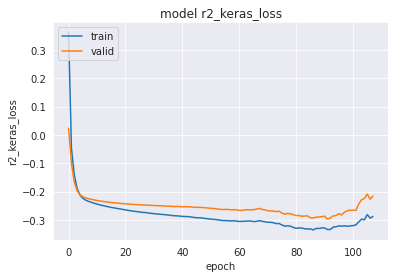

In [24]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '_epoch_' + str(epochs_lambda).zfill(3) + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


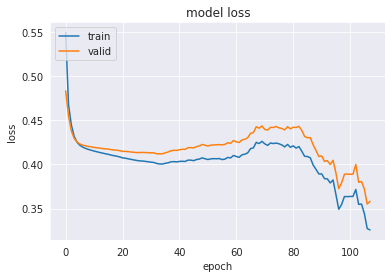

In [25]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '_epoch_' + str(epochs_lambda).zfill(3) + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()
